# Lab 6: Matrix Factorization and Linear Dimensionality Reduction
Covered Topics:
> K-nearest neighbors (KNN) Graph Construction

> Locally Linear Embedding (LLE)

> Laplacian Eigenmaps

# Motivation
> Implement two typical manifold learning methods.

> Try to get some feelings about the sensitivity of these two methods to the structure of their K-NN graphs.

> Try to overcome the numerical instability of LLE.

# Data Dimulator and Testing Function (Don't change them)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# don't add any other packages


# data simulator and testing function (Don't change them)
def simulate_3d_manifold(
    n_pts: int = 500, noise_level: float = 0.01, r_seed: int = 42
) -> dict:
    """
    Simulate a set of 3D points lying on a manifold, the manifold is a 2D geometry embedded in the 3D space.
    :param n_pts: the number of 3D points
    :param r_seed: the random seed
    :param noise_level: the standard deviation of Gaussian noise
    :return:
        a dictionary containing the 3D points with Gaussian noise and their 2D latent codes.
    """

    t1 = 5 * np.pi / 3 * np.random.RandomState(r_seed).rand(n_pts, 1)
    t2 = 5 * np.pi / 3 * np.random.RandomState(1).rand(n_pts, 1)
    latent_code = np.concatenate((t1, t2), axis=1)
    x1 = 3 + np.cos(t1) * np.cos(t2)
    x2 = 3 + np.cos(t1) * np.sin(t2)
    x3 = np.sin(t1)
    data = np.concatenate((x1, x2, x3), axis=1) + noise_level * np.random.RandomState(
        r_seed
    ).randn(n_pts, 3)
    return {"3d": data, "2d": latent_code}


def visualization_3d_pts(pts3d: np.ndarray, prefix: str = "data"):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2])
    plt.title("{}_3d".format(prefix))
    # plt.savefig("{}_3d.png".format(prefix))
    # plt.close()


def visualization_2d_pts(pts2d: np.ndarray, prefix: str = "data"):
    plt.figure(figsize=(12, 12))
    plt.scatter(pts2d[:, 0], pts2d[:, 1])
    plt.title("{}_2d".format(prefix))
    # plt.savefig("{}_2d.png".format(prefix))
    # plt.close()

# Task 1
Construct a K-NN graph of the data points.

# Solution 1
The computation of distance matrix by **broadcasting** is introduced before. To compute the distance matrix between two datasets X and Y, we only need to 

> (1) broadcast X along the 1-th axis and Y along the 0-th axis; 

> (2) Compute the p-distance between each pair of points;

> (3) Sum along the last axis to get the distance matrix.

In [11]:
def distance_matrix(xs: np.ndarray, distance_type: str = "L2") -> np.ndarray:
    """
    Construct a N x N distance matrix from a data matrix with size (N, D)
    :param xs: a data matrix with size (N, D)
    :param distance_type: the type of the distance, which can be "L2" or "L1",
        L2 means d_ij = ||xi - xj||_2, while L1 means d_ij = ||xi - xj||_1
    :return:
        a distance matrix with size (N, N)
    """
    # calculate the distance matrix
    if distance_type == "L2":
        dist = np.sqrt(np.sum((xs[:, np.newaxis] - xs[np.newaxis, :, :]) ** 2, axis=-1))
    elif distance_type == "L1":
        dist = np.sum(np.abs(xs[:, np.newaxis] - xs[np.newaxis, :, :]), axis=-1)
    else:
        raise ValueError("Unknown distance type")
    return dist

In [12]:
def construct_knn_graph(
    xs: np.ndarray, k: int = 5, distance_type: str = "L2"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Construct a K-NN graph from the data points and output the adjacency matrix and the index matrix
    :param xs: a data matrix with (N, D), N is the number of samples, D is the dimension of sample space
    :param k: the number of principal components we would like to output
    :param distance_type: the type of the distance, which can be "L2" or "L1",
        L2 means d_ij = ||xi - xj||_2, while L1 means d_ij = ||xi - xj||_1
    :return:
        an adjacency matrix with size (N, N)
        an index matrix with size (N, k), the n-th row contains the indices of the neighbors of the n-th sample.
    """
    N = xs.shape[0]
    dist = distance_matrix(xs, distance_type)
    # get k nearest neighbors (excluding the point itself)
    # Each row of `dist`: d(x1,x2), d(x1,x3), ..., d(x1,xN)
    # sort the row and get the indices of the k smallest values (excluding the point itself)
    idx = np.argsort(dist, axis=1)[:, 1:k+1]
    # Initialize adjacency matrix
    adj = np.zeros((N, N))
    # Fill in adjacency matrix
    # m in idx[i]: m is a neighbor of i, so adj[i][m] = 1
    for i in range(N):
        adj[i, idx[i]] = 1
        adj[idx[i], i] = 1  # undirected graph
    return adj, idx

# Task 2
Implement the Locally Linear Embedding (LLE) algorithm.

**Step 1** Construct a $K$-NN graph, for each sample $\boldsymbol{x}_n \in \mathbb{R}^D$, find its $K$ nearest neighbors $\boldsymbol{X}_n\in \mathbb{R}^{D\times K}$.

**Step 2** Solve the locally linear self-representation problem: for $n = 1, \cdots, N$, our optimization problem is
$$
\min_{\boldsymbol{w}_n} \|\boldsymbol{x}_n - \boldsymbol{X}_n\boldsymbol{w}_n\|_2^2,\ s.t.\ \boldsymbol{1}^T\boldsymbol{w}_n = 1
$$
It can be solved (by Lagrange multiplier) as $\boldsymbol{w}_n = \boldsymbol{C}^{-1}\boldsymbol{1}_K$, where $\boldsymbol{C} = (\boldsymbol{X}_n-\boldsymbol{x}_n \boldsymbol{1}_K^\top)^\top (\boldsymbol{X}_n-\boldsymbol{x}_n \boldsymbol{1}_K^\top)$.

**Step3** Construct the alignment matrix $\boldsymbol{\Phi}$ based on the weights $\{\boldsymbol{w}_n\}$ and obtain the latent codes by eigenvalue decomposition.







# Solution 2
**Pay attention to the dimension of matrices:** The original dataset $\boldsymbol{X}=[\boldsymbol{x}_1,\cdots,\boldsymbol{x}_n]^\top \in \mathbb{R}^{N\times D}$, in which each sample $\boldsymbol{x}_n \in \mathbb{R}^{D\times 1}$ and its $K$ neighbors $\boldsymbol{X}_n \in \mathbb{R}^{D\times K}$. The covariance matrix $\boldsymbol{C}\in \mathbb{R}^{K\times K}$ matrix, and $\boldsymbol{w}_n\in \mathbb{R}^{K\times 1}$. 

All $\{\boldsymbol{w}_n^\top \}$ can be stacked vertically into a $N\times K$ matrix $\boldsymbol{W}$, and it's further extended to a $N\times N$ alignment matrix where the rest of entries are zeros. The alignment matrix $\boldsymbol{\Phi}$ is constructed by
$$
\boldsymbol{\Phi} = (\boldsymbol{I} - \boldsymbol{W})^\top (\boldsymbol{I} - \boldsymbol{W})=\boldsymbol{I} - \boldsymbol{W} - \boldsymbol{W}^\top + \boldsymbol{W}^\top \boldsymbol{W}
$$
The latent codes are obtained by the eigen-decomposition of $\boldsymbol{\Phi}$. We take the second smallest to the $L+1$-smallest eigenvectors as the latent codes $\boldsymbol{Z}$.



In [27]:
def locally_linear_embedding(
    xs: np.ndarray, k: int = 5, dim: int = 2, distance_type: str = "L2"
) -> np.ndarray:
    """
    Implement the locally linear embedding algorithm
    :param xs: the data matrix with size (N, D), N is the number of samples
    :param k: the number of neighbors per sample in the K-NN graph
    :param dim: the dimension of latent code, where dim < D
    :param distance_type: the type of the distance, which can be "L2" or "L1",
        L2 means d_ij = ||xi - xj||_2, while L1 means d_ij = ||xi - xj||_1
    :return:
        ys: the latent codes of the data, with size (N, dim)
    """
    N = xs.shape[0]
    _, idx = construct_knn_graph(xs, k, distance_type)
    # Initialize W matrix
    W = np.zeros((N, N))
    # Compute W, size (N, N)
    # Each row `i` of `W`` is the coefficient of neighbors of sample `x_i``
    for i in range(N):
        # Get the neighbors of the i-th sample
        neighbors = xs[idx[i]].T    # neighbors: (D, k)
        diff = neighbors - xs[i].reshape(-1, 1) @ np.ones((1, k))  # diff: (D, k)
        C = diff.T @ diff   # C: (k, k)
        # Slightly modify C to ensure invertibility
        C += 1e-6 * np.eye(k)
        w_i = np.linalg.inv(C) @ np.ones(k) # w_i: (k,)
        W[i][idx[i]] = w_i 
    # Construct the alignment matrix
    Phi = np.eye(N) - W - W.T + W.T @ W     # Phi: (N, N)
    # Calculate the eigenvectors and eigenvalues of Phi
    eigvals, eigvecs = np.linalg.eigh(Phi)
    # Sort the eigenvectors in ascending order of eigenvalues
    idx = np.argsort(eigvals)
    eigvecs = eigvecs[:, idx]
    # Get the first `dim` eigenvectors (`dim` smallest eigenvalues)
    ys = eigvecs[:, 1:dim+1]                # ys: (N, dim)
    return ys

# Task 3
Implement the Laplacian Eigenmaps. The Laplacian matrix can be derived based on the dense similarity matrix or the sparse similarity matrix modulated by the adjacency matrix of the K-NN graph.

# Solution 3
Laplacian Eigenmap is a method for dimensionality reduction with the help of **similarity matrix**. The process of Laplacian Eigenmap is as follows:

Given a set of data $\boldsymbol{X}= \{\boldsymbol{x}_1,\cdots,\boldsymbol{x}_N\}\in \mathbb{R}^{N\times D}$, we construct the similarity matrix $\boldsymbol{A}=[a(\boldsymbol{x_i},\boldsymbol{x_j})]\in \mathbb{R}^{N\times N}$. A reasonable criterion to get the low-dimensional embedding $\boldsymbol{Z}=[\boldsymbol{z}_1,\cdots,\boldsymbol{z}_N]\in \mathbb{R}^{L\times N}$ is to minimize the following objective function
\begin{align*}
    \min\limits_{\boldsymbol{Z}}\sum\limits_{m,n=1}^{N} \| \boldsymbol{z}_m-\boldsymbol{z}_n\|_2^2 a(\boldsymbol{x_m},\boldsymbol{x_n})
\end{align*}
because when distance $\| \boldsymbol{z}_m-\boldsymbol{z}_n\|_2^2$ is small, the similarity $a(\boldsymbol{x_m},\boldsymbol{x_n})$ should be large. 
\begin{align*}
    \boldsymbol{Z}&=\arg \min\limits_{\boldsymbol{Z}}\sum\limits_{m,n=1}^{N} \| \boldsymbol{z}_m-\boldsymbol{z}_n\|_2^2 a(\boldsymbol{x_m},\boldsymbol{x_n})=\arg\min\limits_{\boldsymbol{Z}}\sum\limits_{m,n=1}^{N} (\boldsymbol{z_m}^\top \boldsymbol{z_m}-2\boldsymbol{z_m}^\top \boldsymbol{z_n}+\boldsymbol{z_n}^\top \boldsymbol{z_n})a_{mn}\\
    &=\arg\min\limits_{\boldsymbol{Z}}\sum\limits_{m=1}^{N}\boldsymbol{z_m}^\top \boldsymbol{z_m}\left(\sum\limits_{n=1}^{N}a_{mn}\right)+\sum\limits_{n=1}^{N}\boldsymbol{z_n}^\top \boldsymbol{z_n}\left(\sum\limits_{m=1}^{N}a_{mn}\right)-2\sum\limits_{m,n=1}^{N}\boldsymbol{z_m}^\top \boldsymbol{z_n}a_{mn}\\
    &=\arg\min\limits_{\boldsymbol{Z}}2\text{tr}(\boldsymbol{Z}^\top \text{diag}(\boldsymbol{A1_N})\boldsymbol{Z})-2\text{tr}(\boldsymbol{Z^\top AZ})\\
    &=\arg\min\limits_{\boldsymbol{Z}}2\text{tr}(\boldsymbol{Z}^\top (\text{diag}(\boldsymbol{A1_N})-\boldsymbol{A})\boldsymbol{Z})\\
    &=\arg\min\limits_{\boldsymbol{Z}}\text{tr}(\boldsymbol{Z}^\top \boldsymbol{LZ}) \quad \text{where\ }\boldsymbol{L}=\text{diag}(\boldsymbol{A1_N})-\boldsymbol{A}
\end{align*}
By performing EVD on the **Laplacian Matrix** $\boldsymbol{L}:=\boldsymbol{U\Lambda U}^\top$, we can get the embedding $\boldsymbol{Z}^*=\boldsymbol{U_L}\in \mathbb{R}^{N\times L}$.

[Note]: In construction of similarity matrix $\boldsymbol{A}$, we can apply the Gram matrix of kernel function such as the RBF kernel:
\begin{align*}
    a(\boldsymbol{x_i},\boldsymbol{x_j}):=K(\boldsymbol{x_i},\boldsymbol{x_j})=\exp(-\|\boldsymbol{x_i}-\boldsymbol{x_j}\|_2^2/h)
\end{align*}

[Note]: The Laplacian matrix $\boldsymbol{L}$ can be normalized as $\boldsymbol{L}_{norm}=\boldsymbol{D}^{-1/2}\boldsymbol{L}\boldsymbol{D}^{-1/2}$, where $\boldsymbol{D}=\text{diag}(\boldsymbol{A1_N})$.


In [25]:
def laplacian_eigenmaps(
    xs: np.ndarray,
    k: int = None,
    dim: int = 2,
    normalize: bool = True,
    bandwidth: float = 4,
) -> np.ndarray:
    """
    Implement the Laplacian Eigenmap algorithm
    :param xs: the data matrix with size (N, D), N is the number of samples
    :param k: the number of neighbors per sample in the K-NN graph, if k is None, we obtain a fully-connected graph
    :param dim: the dimension of latent code, where dim < D
        L2 means d_ij = ||xi - xj||_2, while L1 means d_ij = ||xi - xj||_1
    :param normalize: use normalized Laplacian or not
    :param bandwidth: the bandwidth of kernel for computing the similarity matrix
    :return:
        ys: the latent codes of the data, with size (N, dim)
    """
    N = xs.shape[0]
    # Construct the similarity matrix
    dist = distance_matrix(xs)  # dist: (N, N)
    A = np.exp(-dist ** 2 / bandwidth)  # A: (N, N)

    # Construct the Laplacian matrix
    L = np.diag(A @ np.ones(N)) - A     # L: (N, N)
    
    # Sparse similarity matrix
    if k is not None:
        # get KNN adj matrix
        Adj, _ = construct_knn_graph(xs, k)
        L = L * Adj

    # Normalization
    if normalize:
        D = np.diag((A @ np.ones(N)) ** (-1/2))
        L = D @ L @ D
    
    # Calculate the eigenvectors and eigenvalues of L
    eigvals, eigvecs = np.linalg.eigh(L)
    # Sort the eigenvectors in ascending order of eigenvalues
    idx = np.argsort(eigvals)
    eigvecs = eigvecs[:, idx]
    # Get the first `dim` eigenvectors (`dim` smallest eigenvalues)
    ys = eigvecs[:, 1:dim+1]            # ys: (N, dim)
    return ys


# Test Script

/var/folders/wz/4cyv558d01jb0_wb8_71vmz00000gn/T/ipykernel_88693/1722924287.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 12))


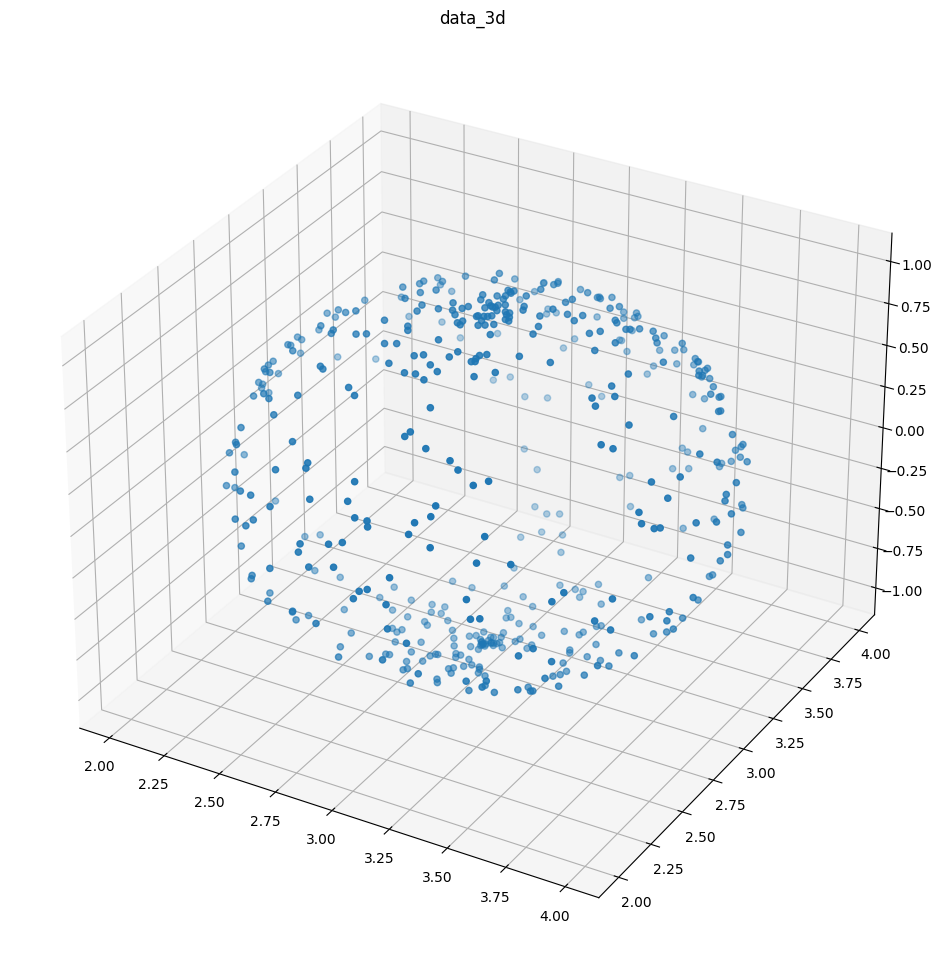

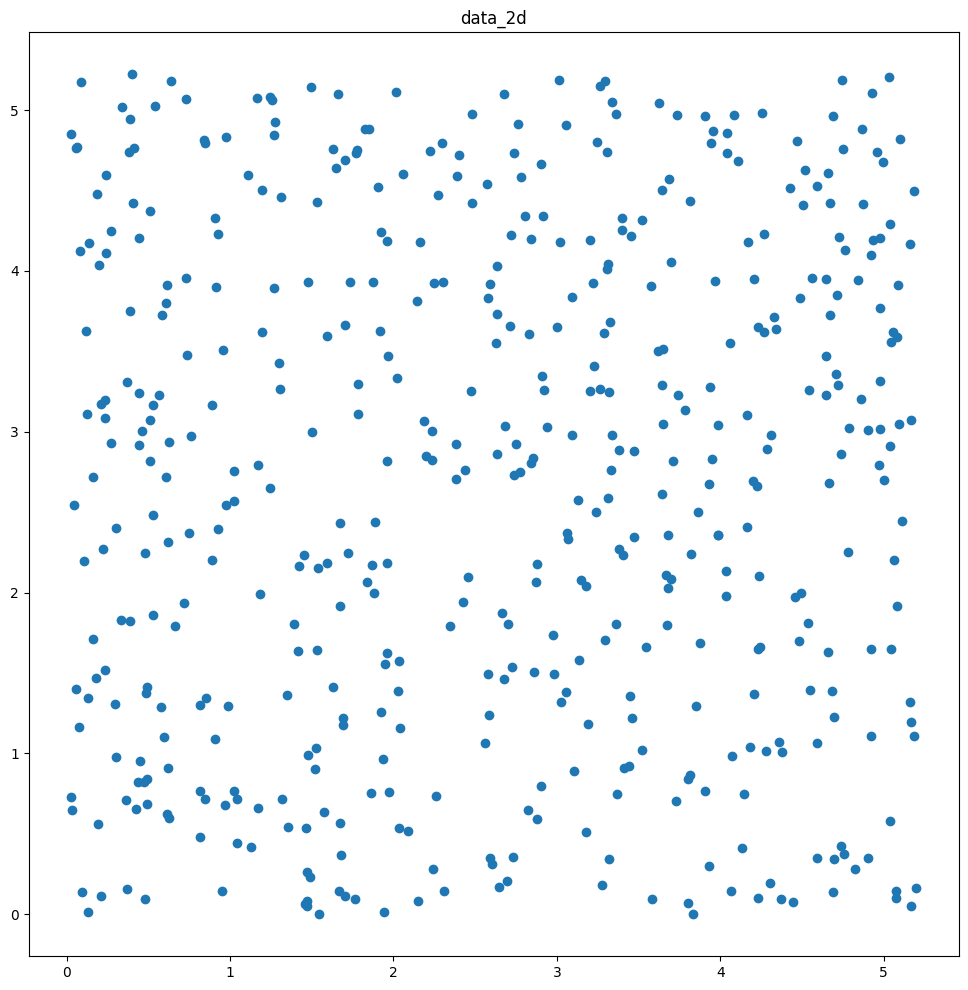

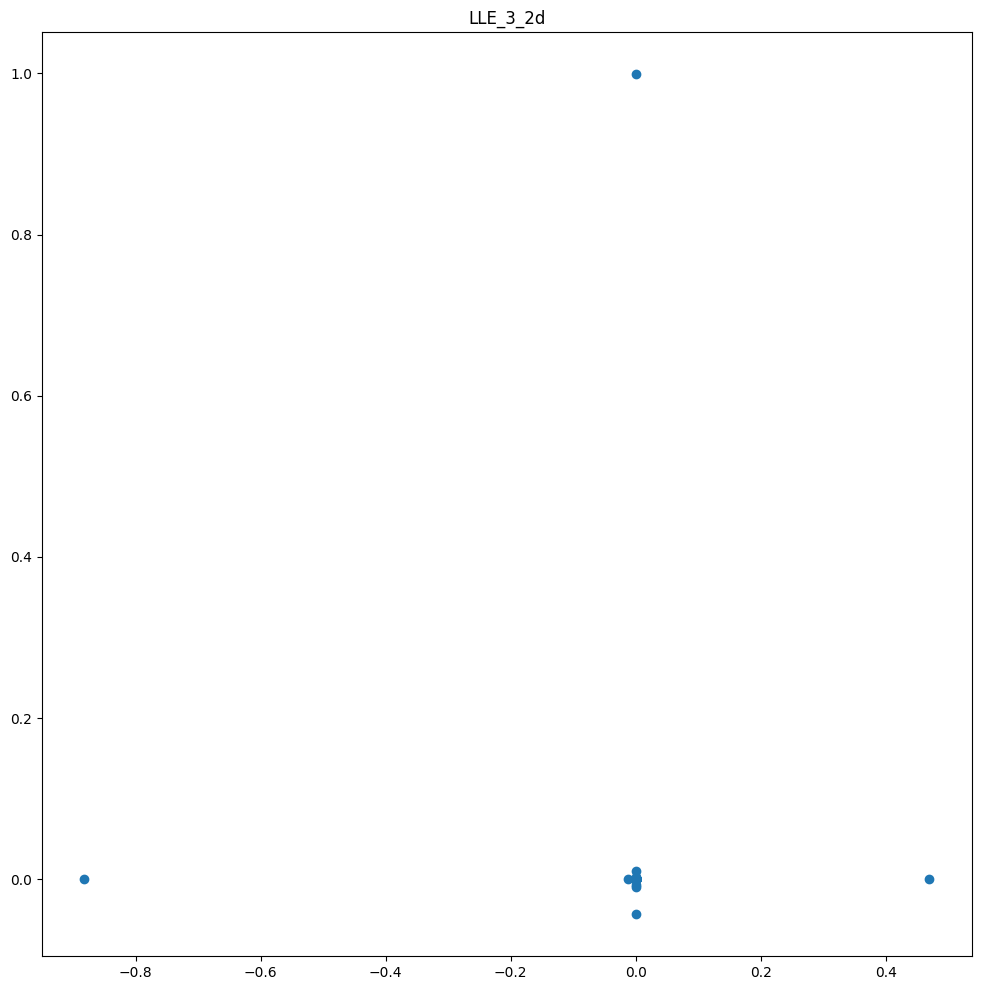

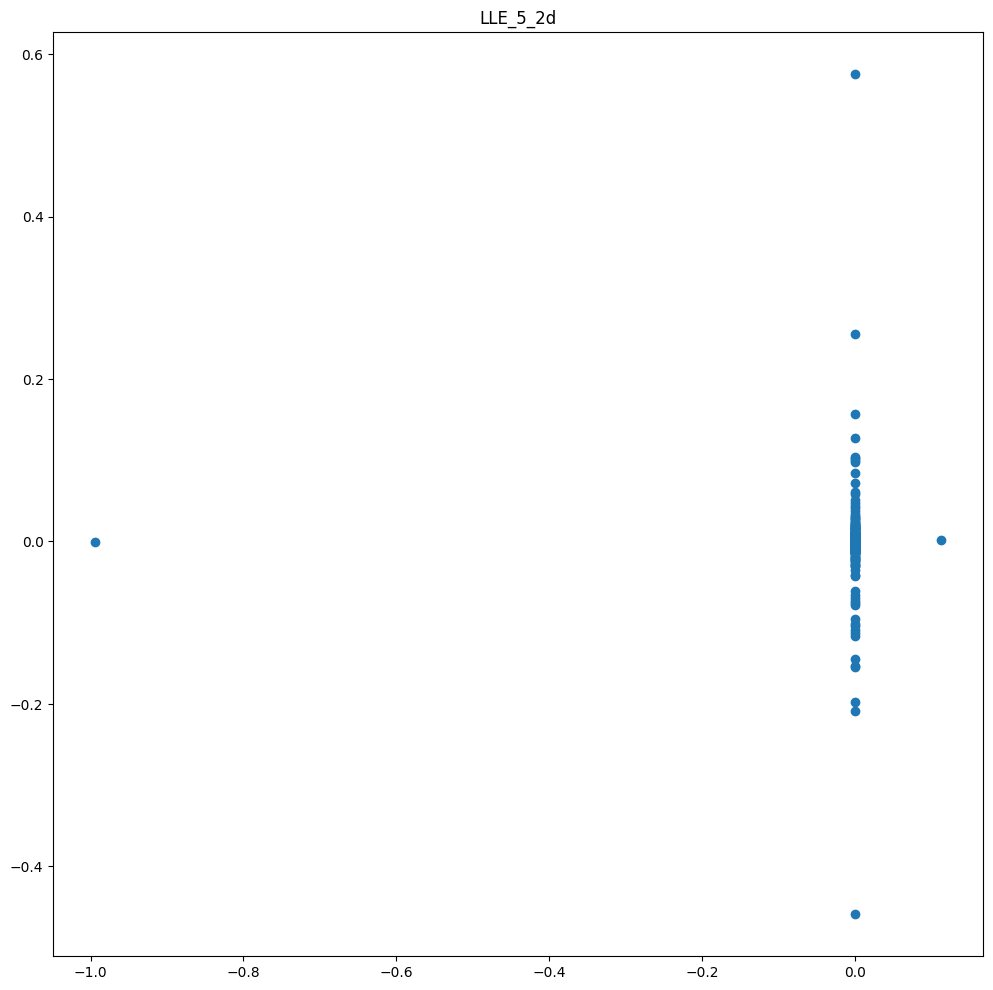

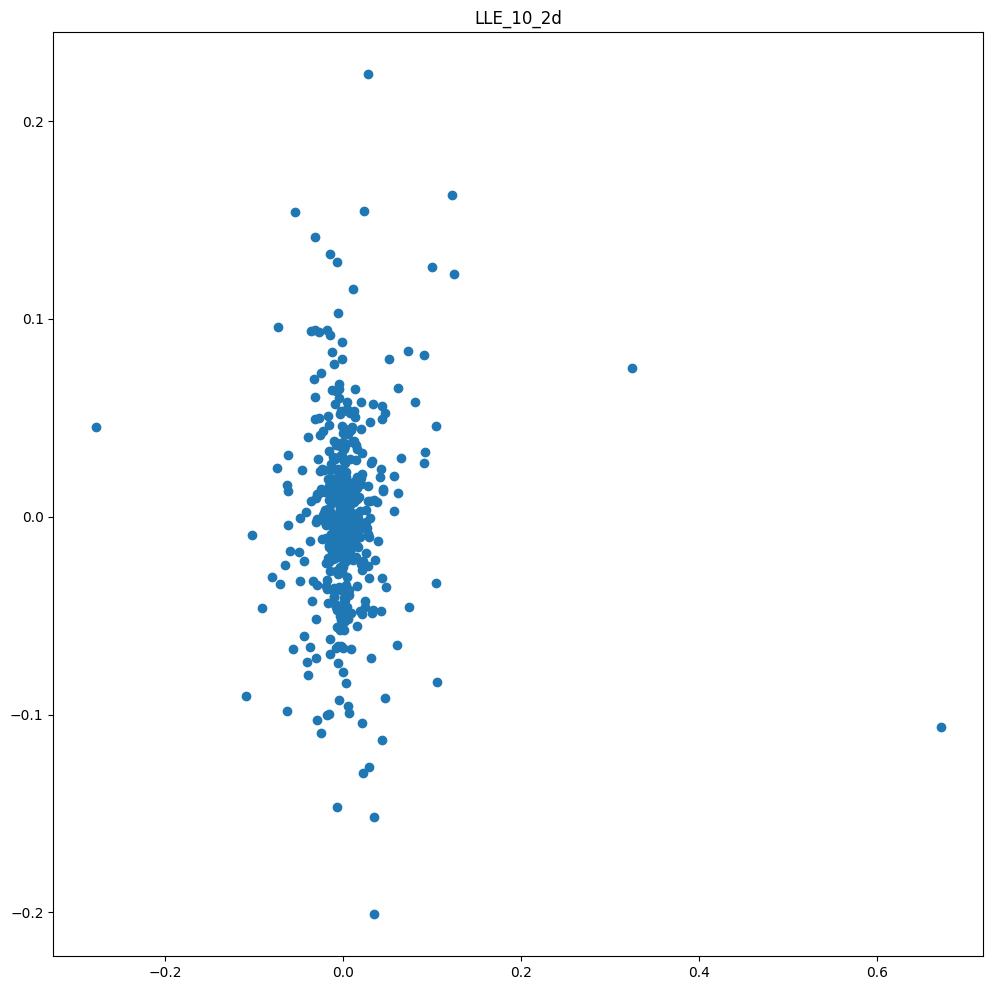

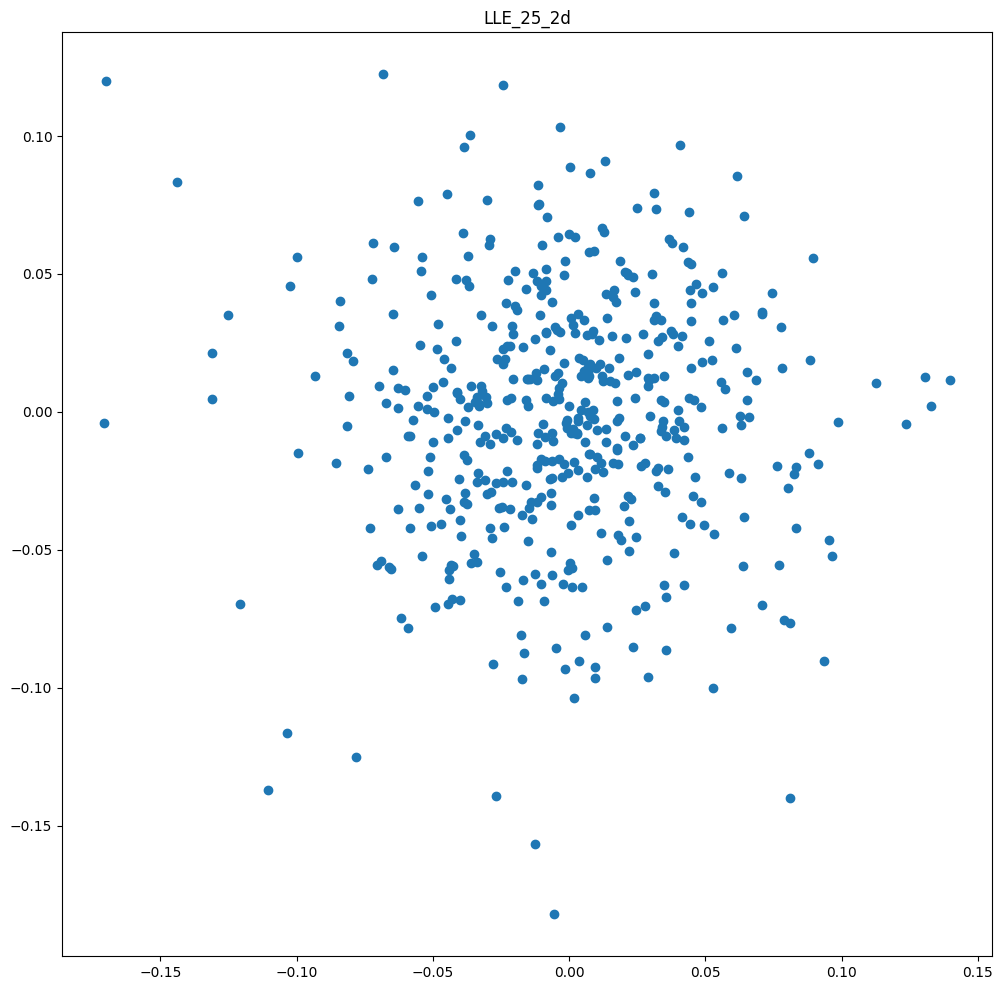

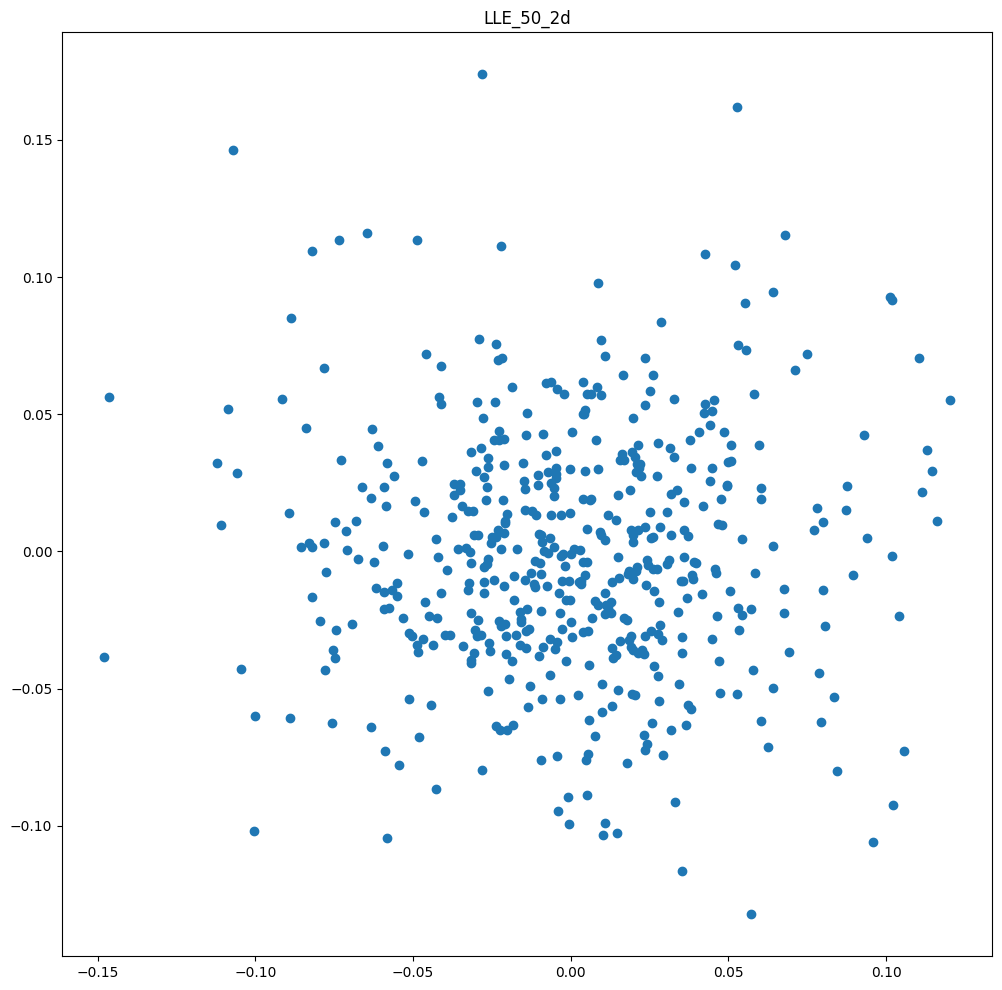

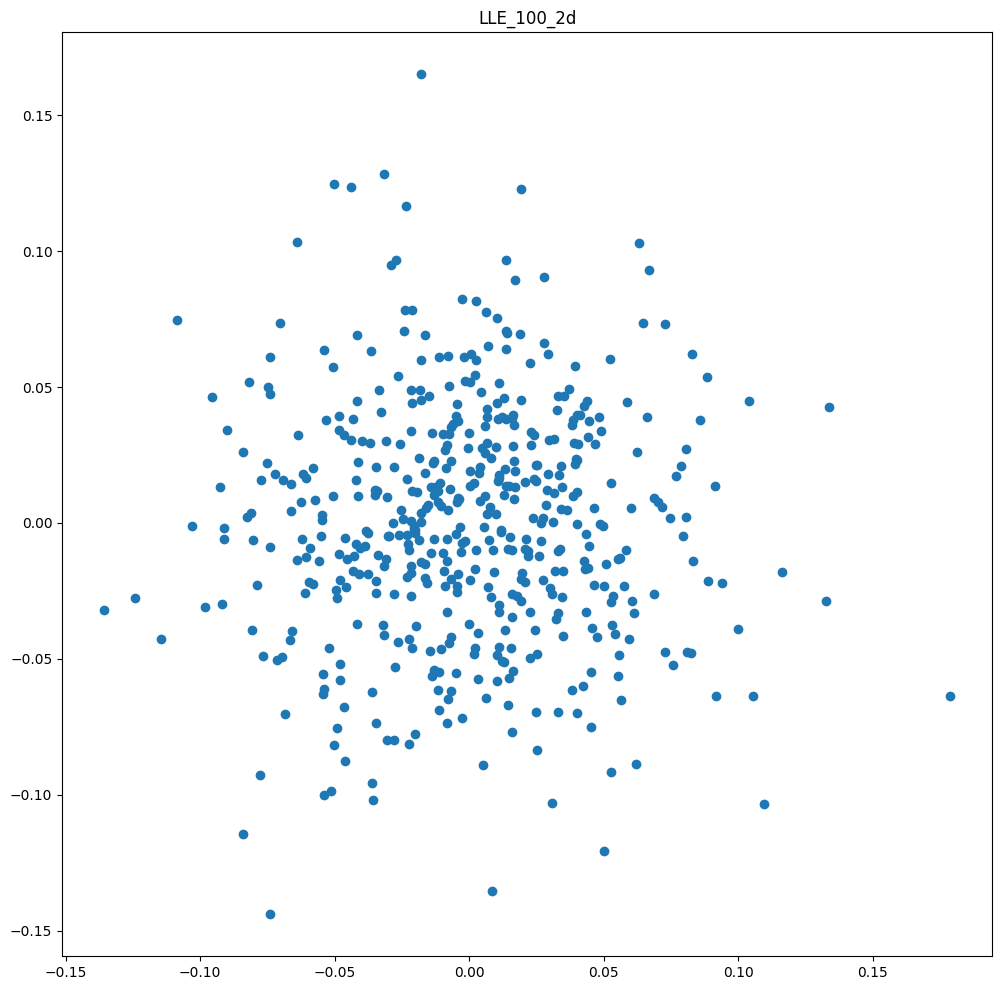

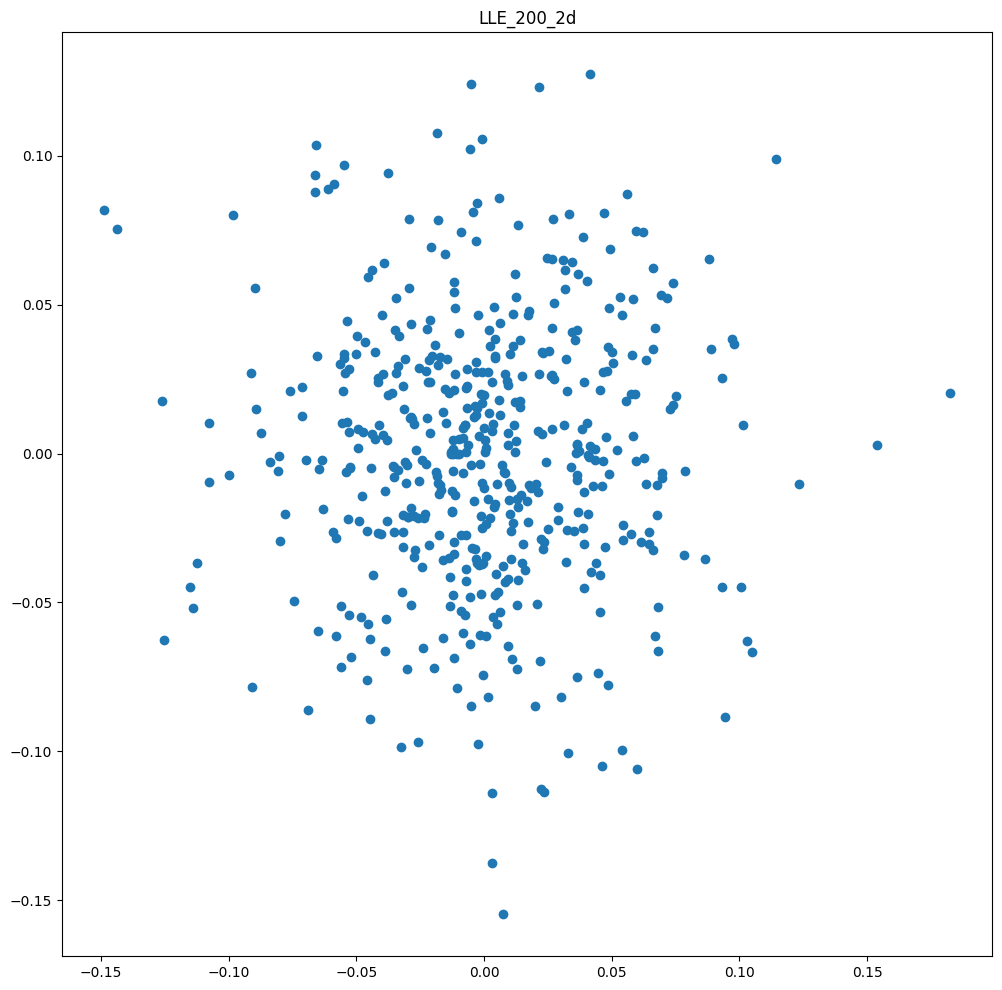

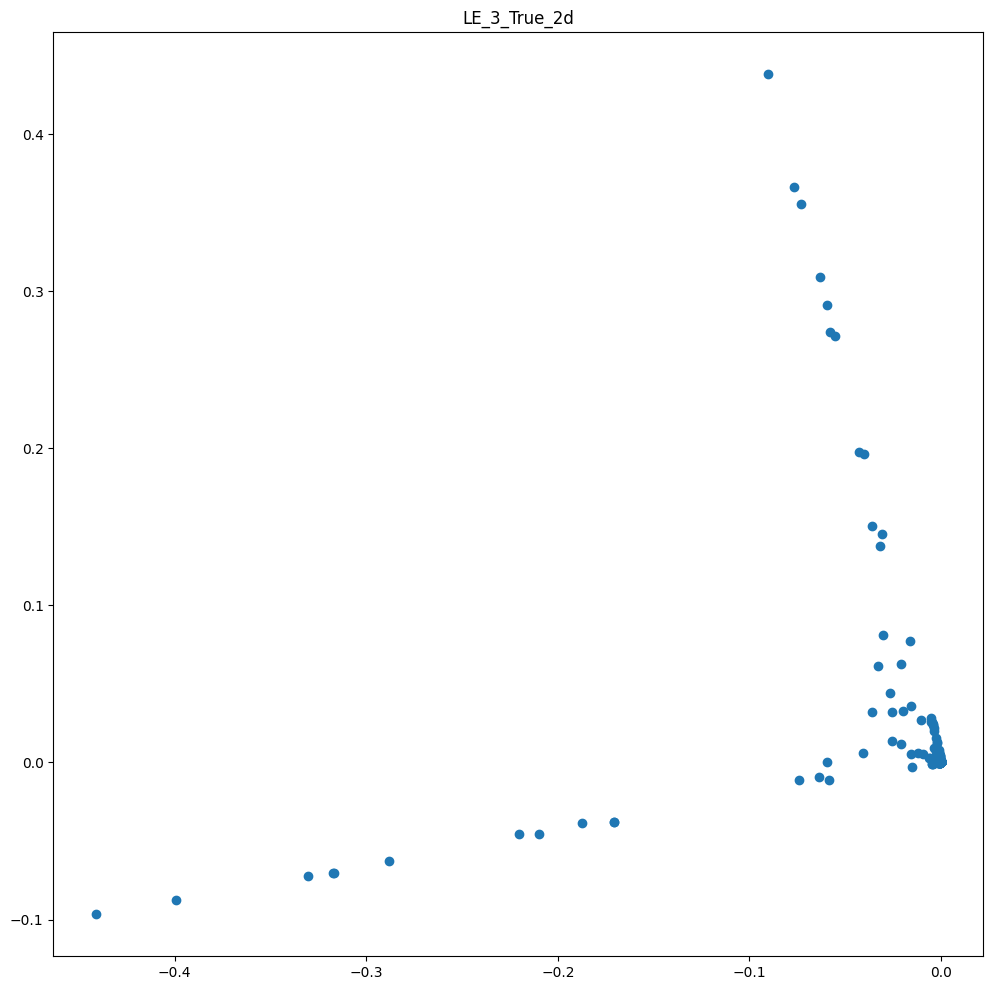

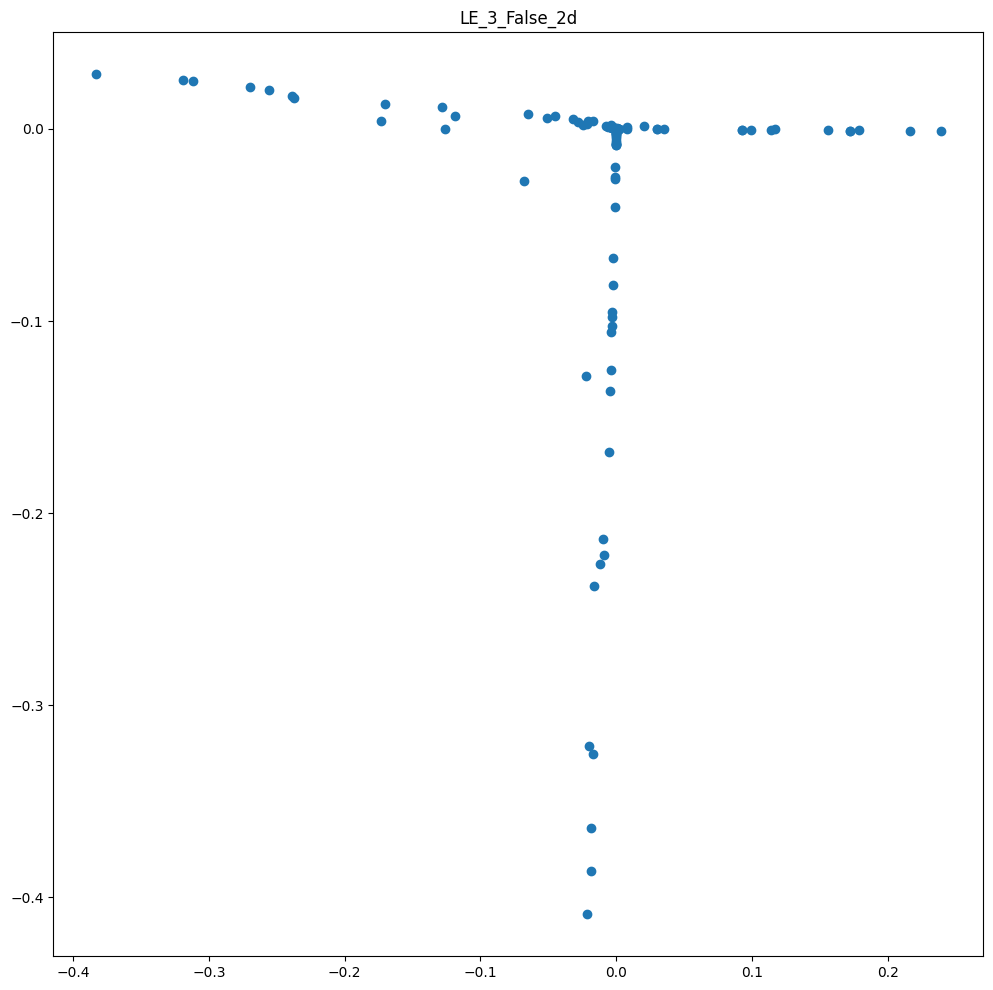

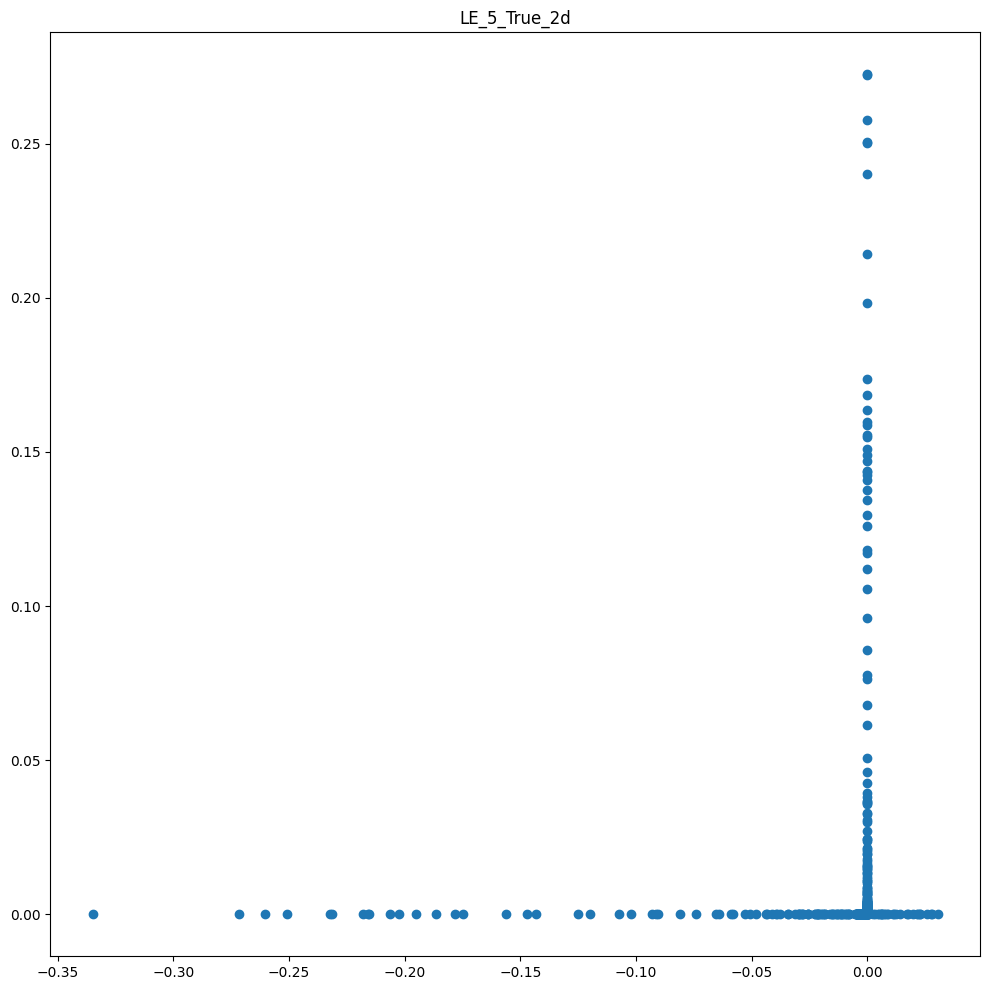

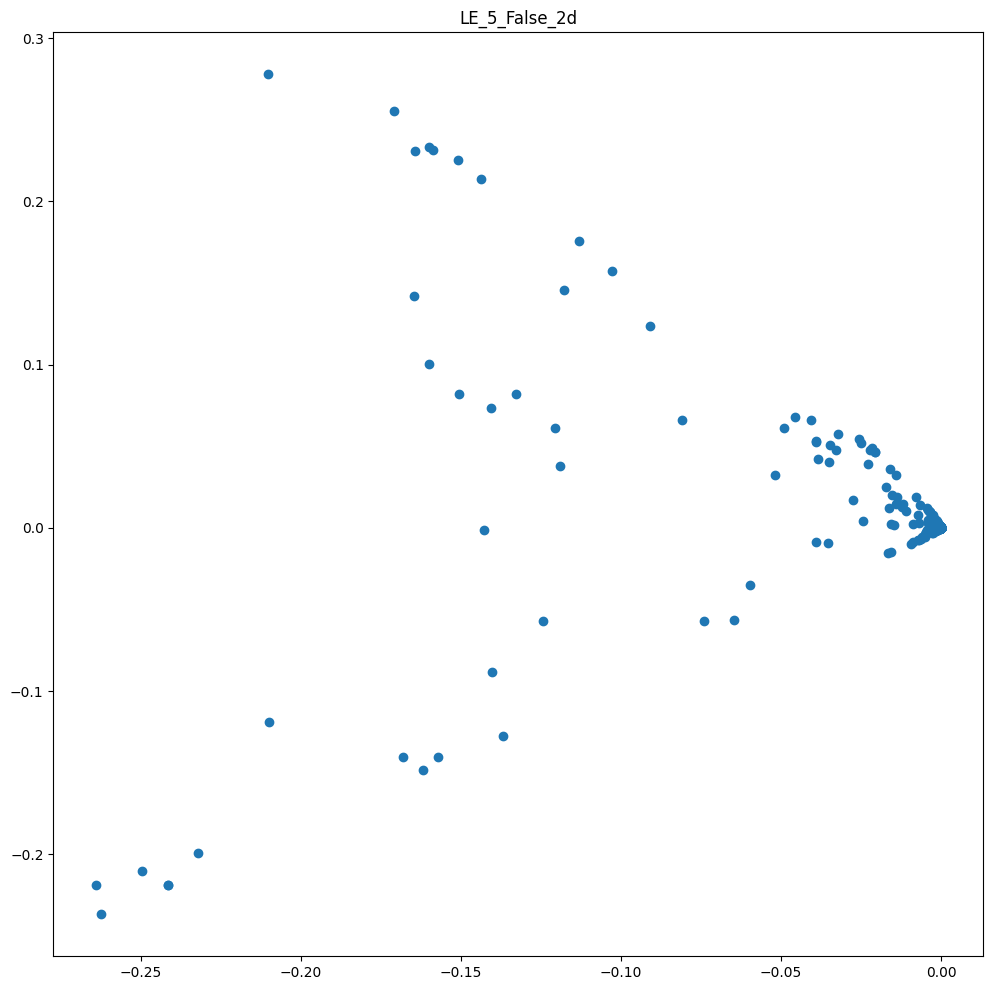

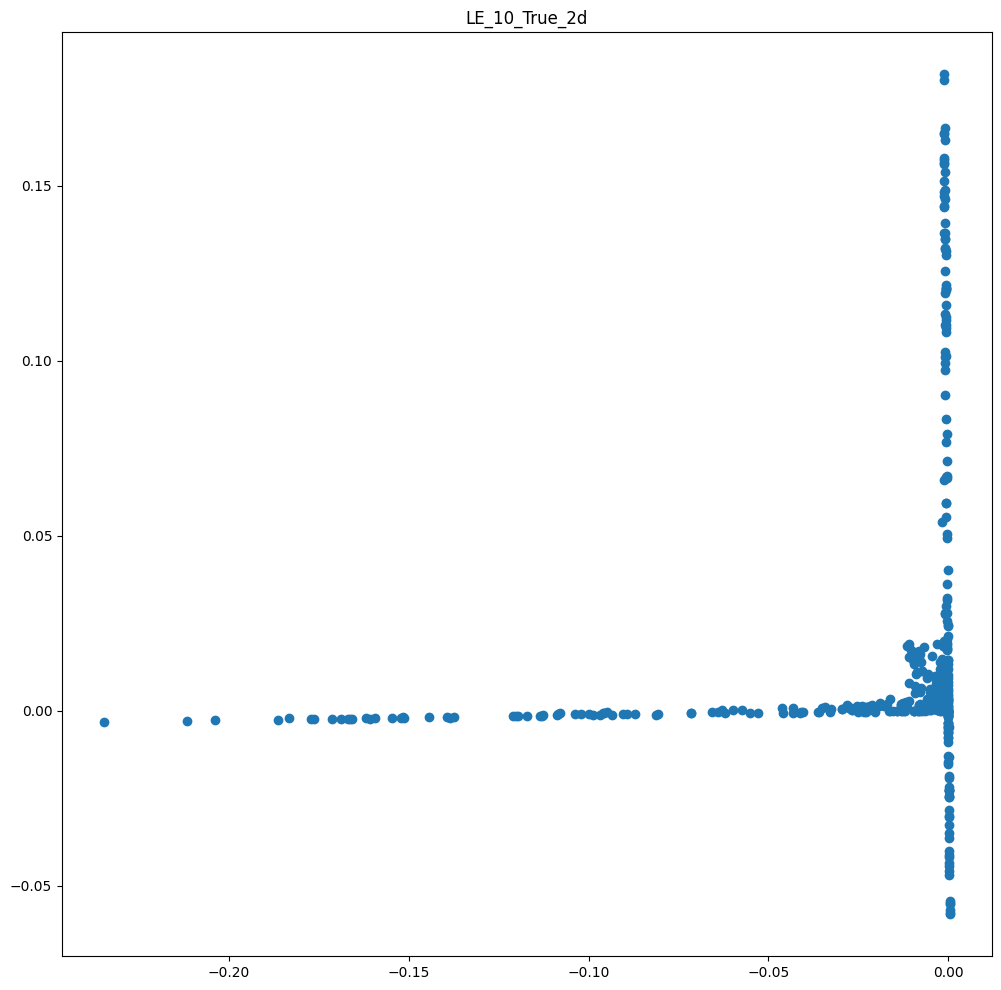

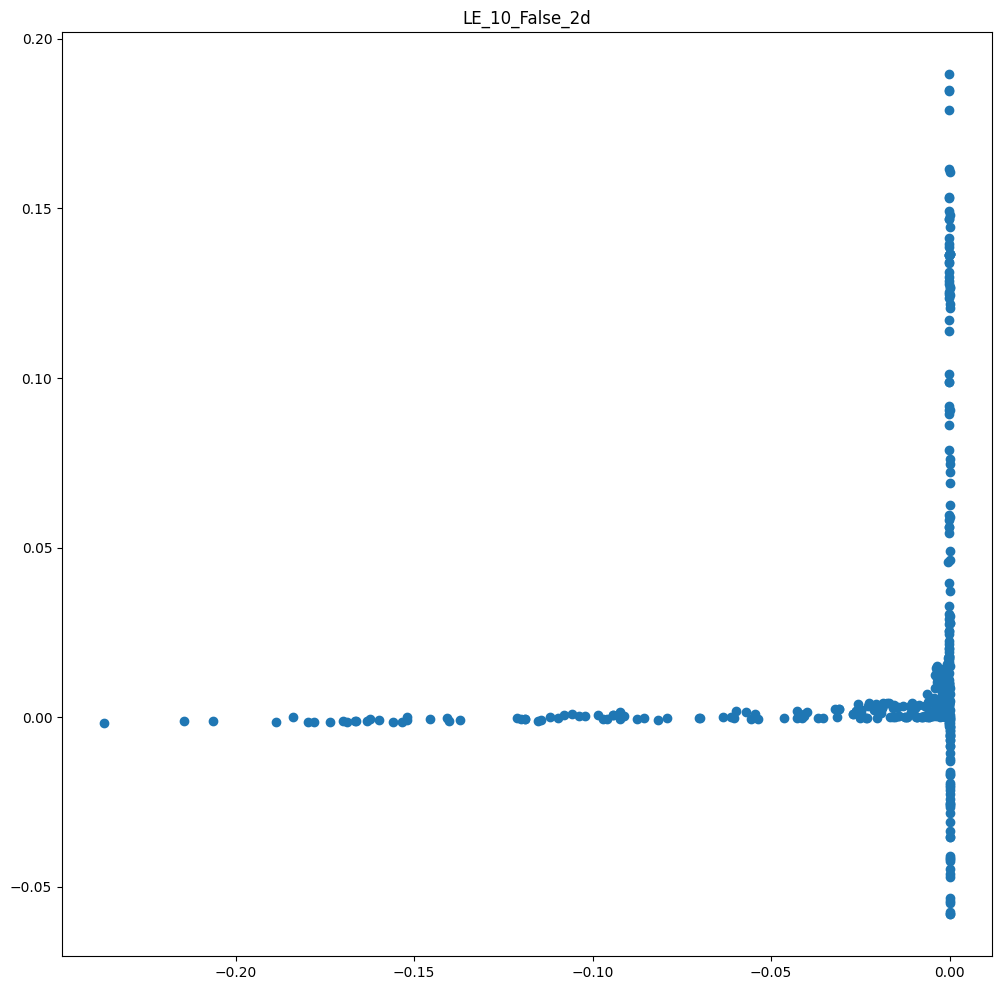

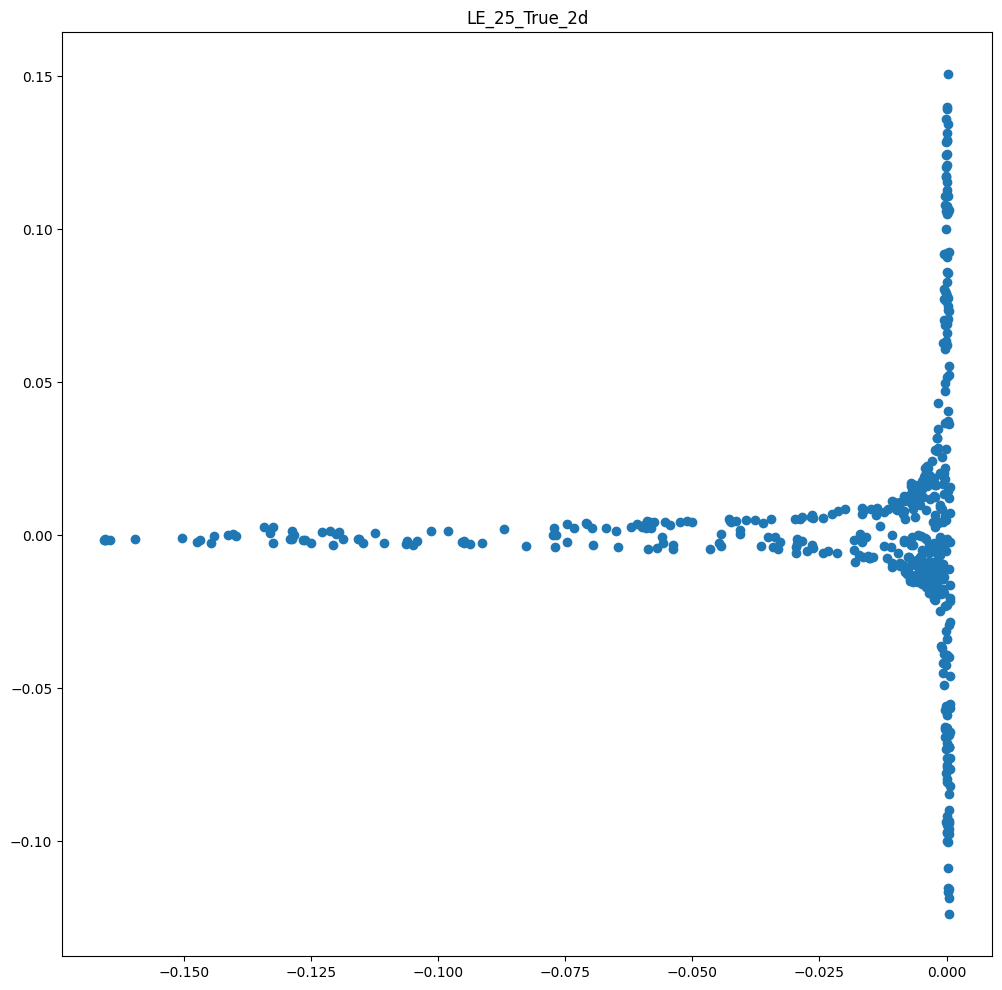

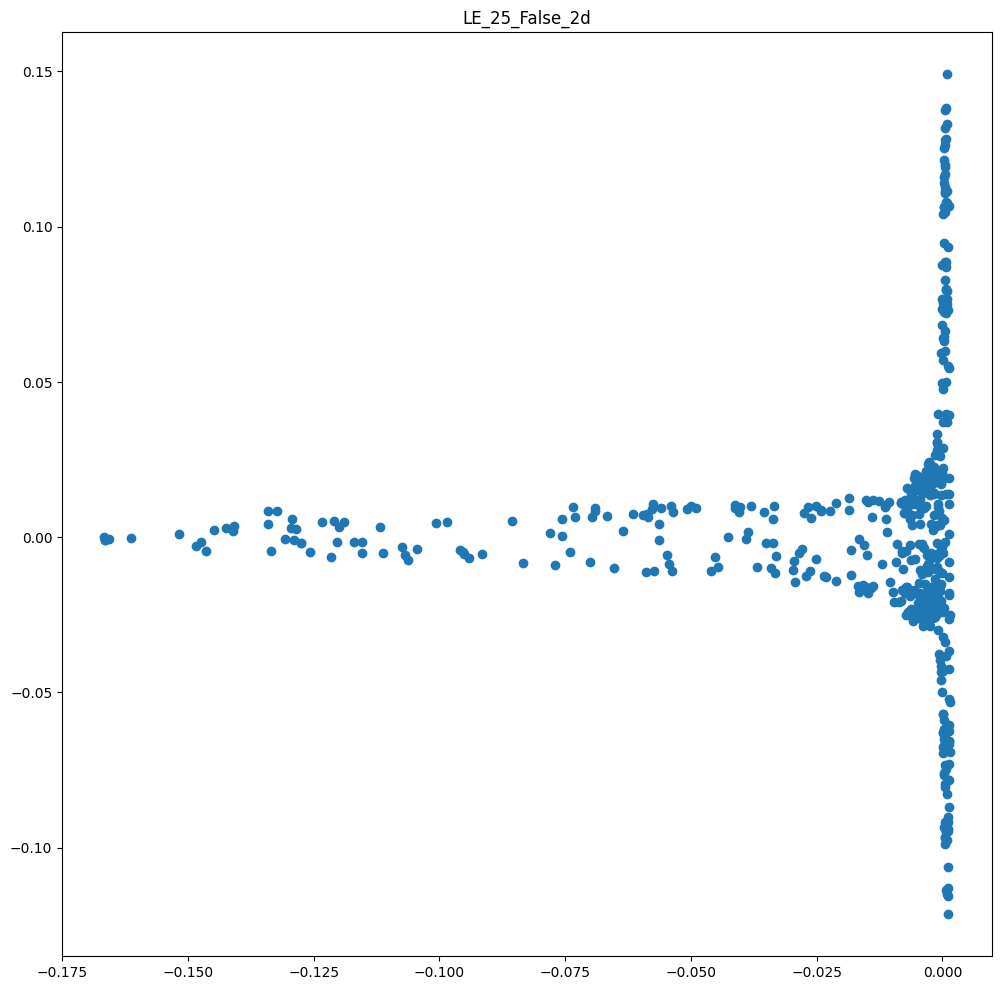

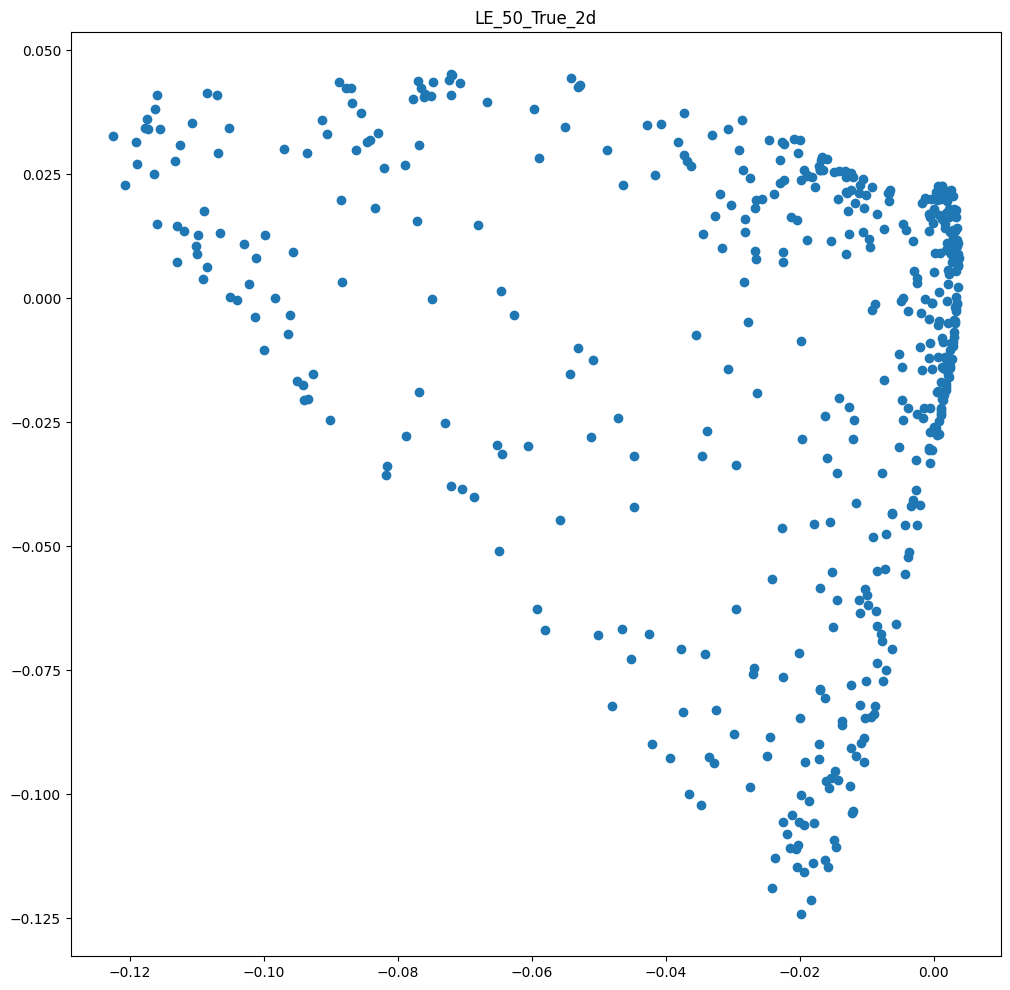

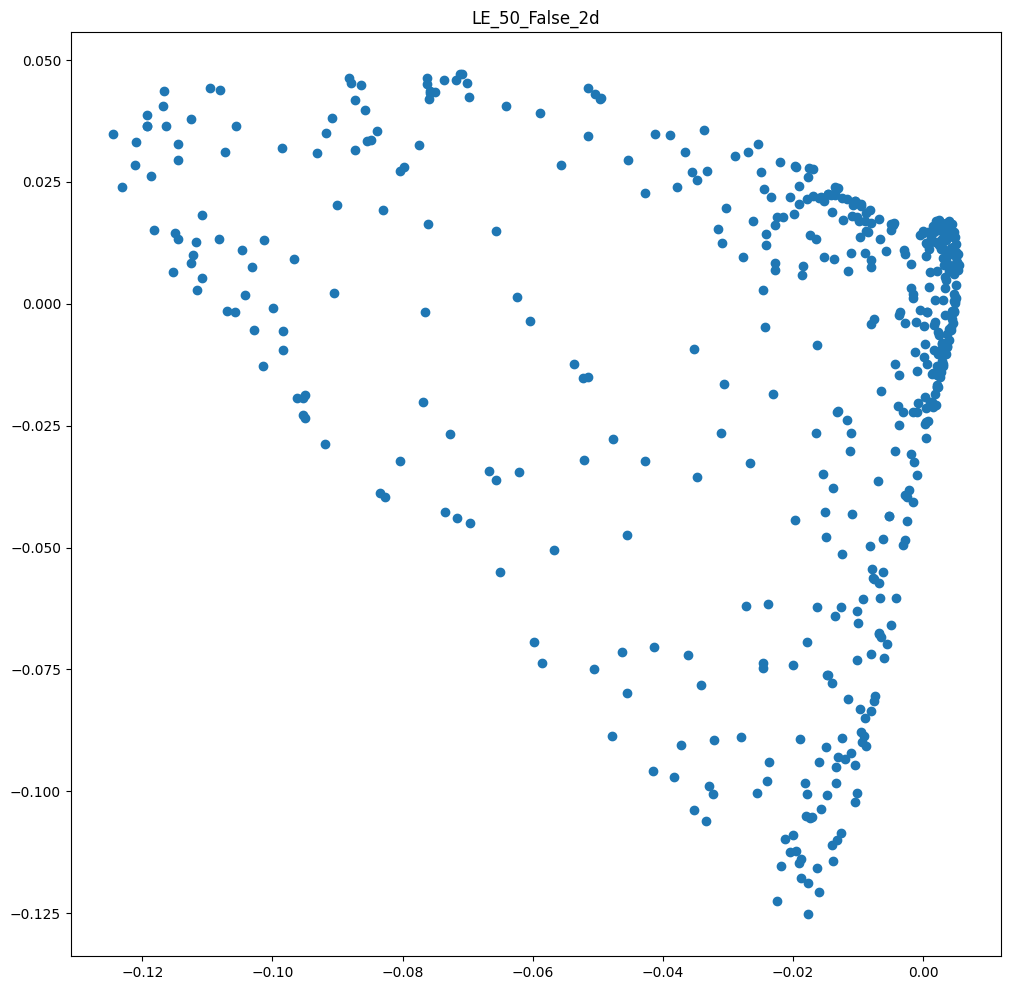

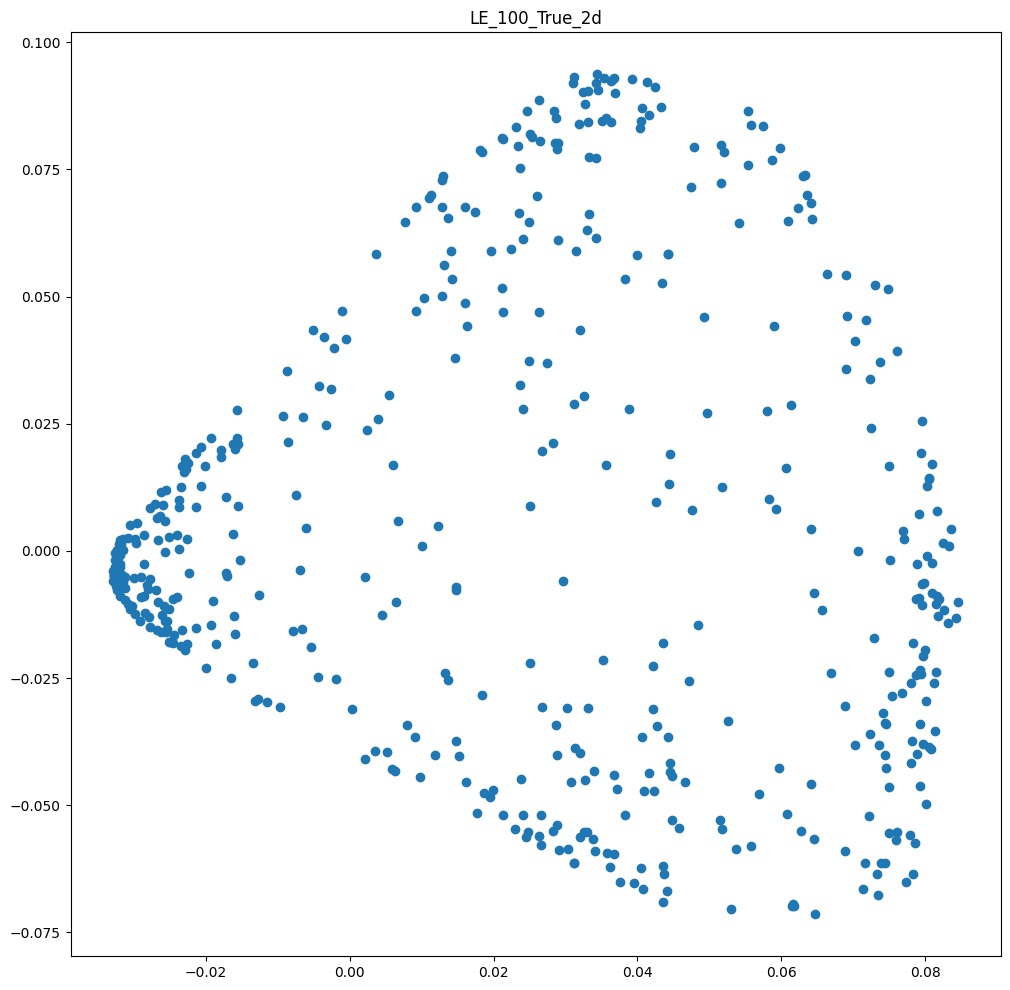

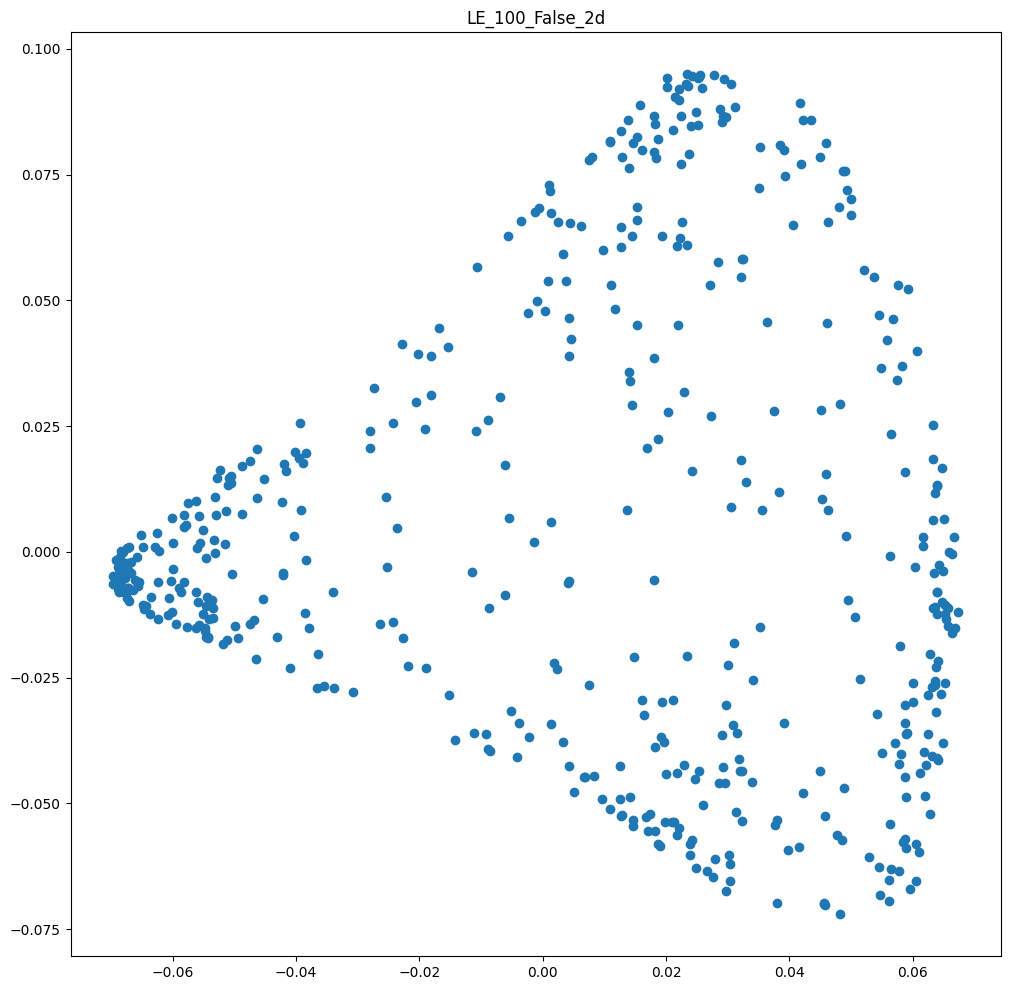

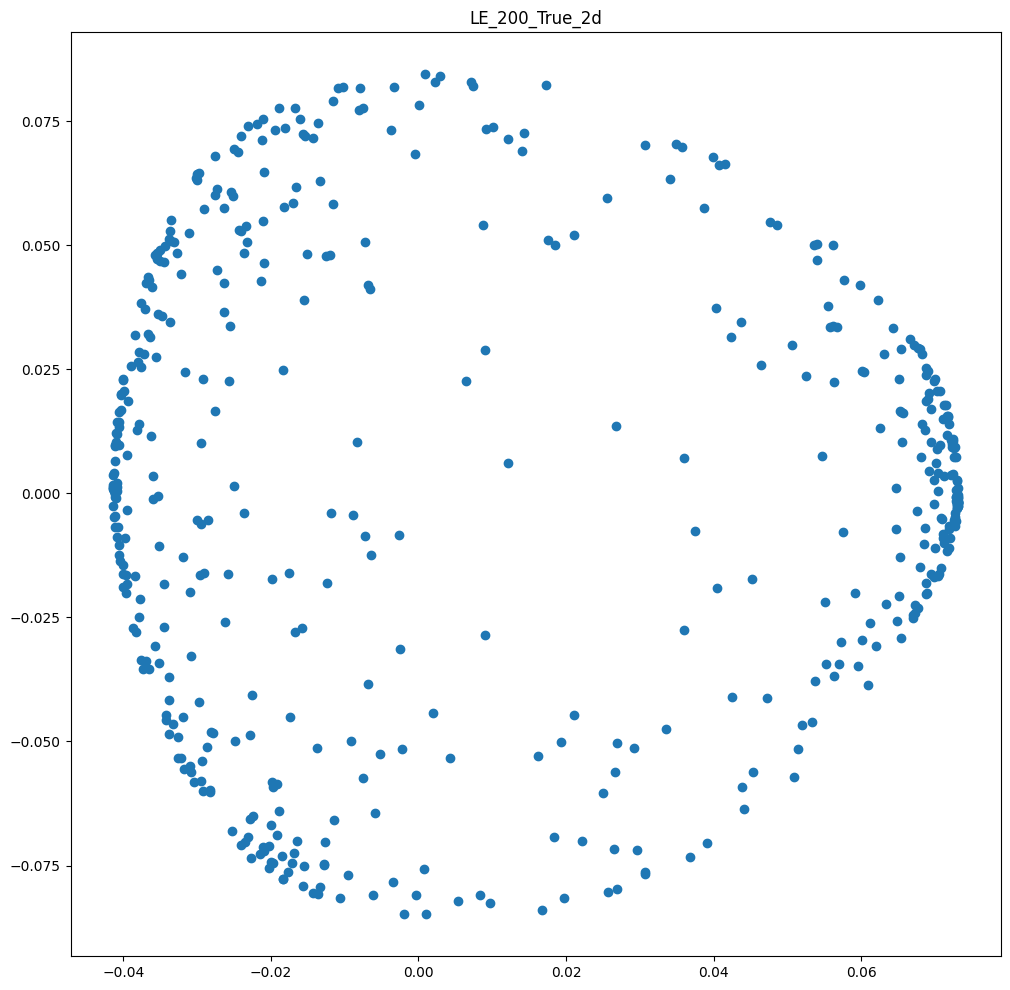

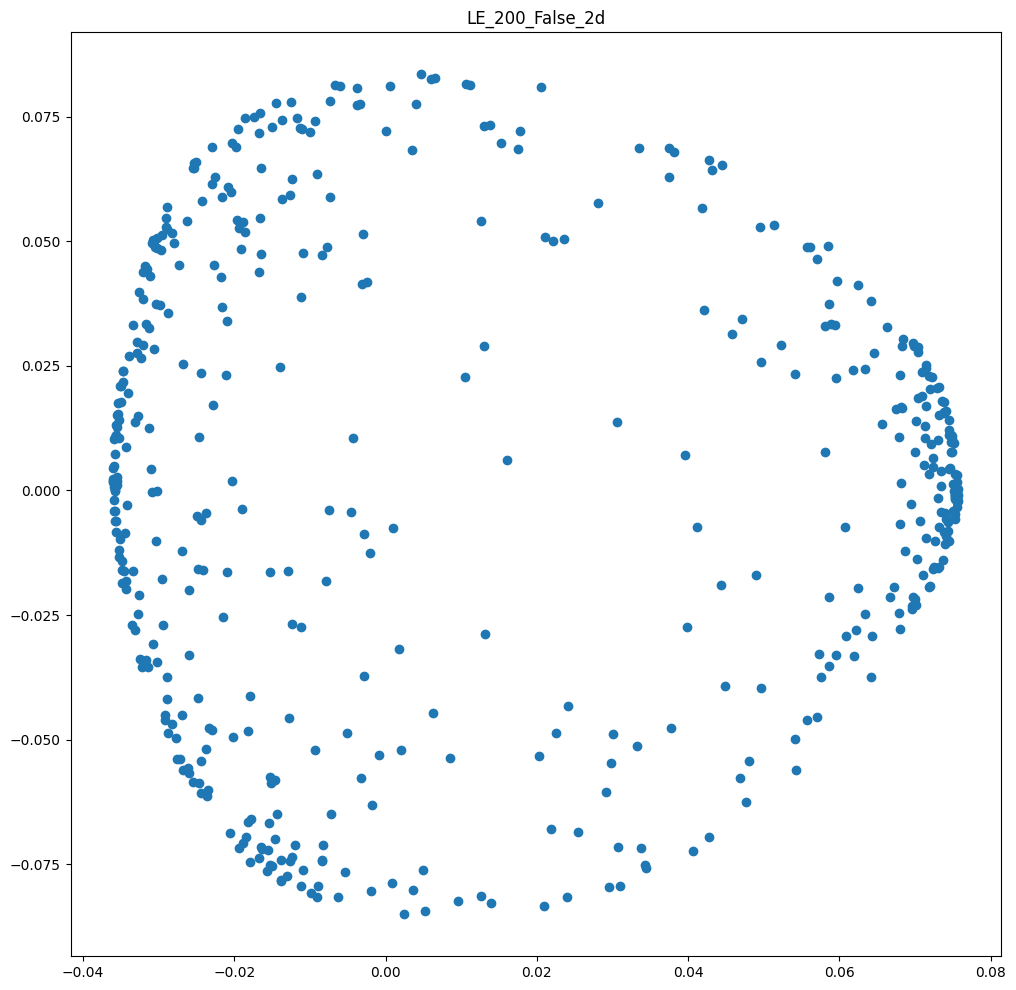

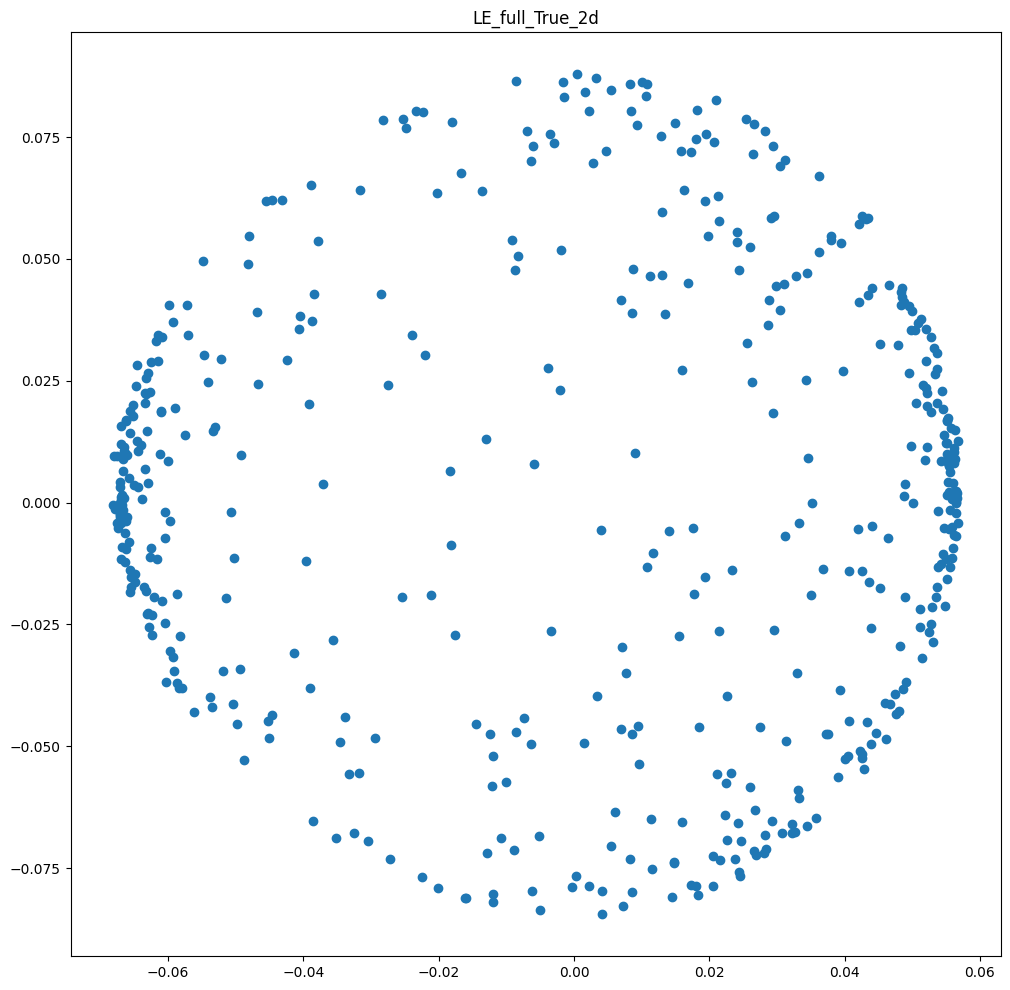

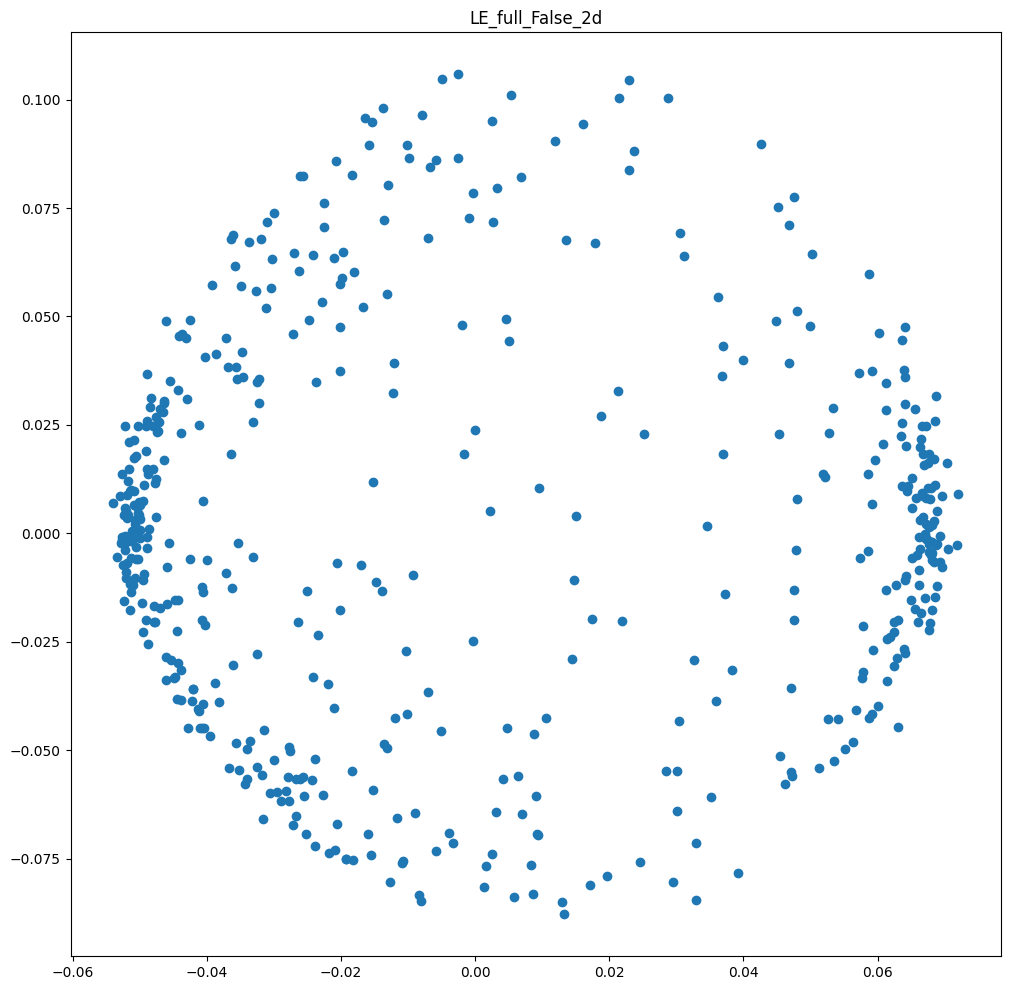

In [26]:
if __name__ == "__main__":
    data = simulate_3d_manifold()
    visualization_3d_pts(data["3d"], prefix="data")
    visualization_2d_pts(data["2d"], prefix="data")
    for k in [3, 5, 10, 25, 50, 100, 200]:
        z1 = locally_linear_embedding(xs=data["3d"], k=k)
        visualization_2d_pts(z1, prefix="LLE_{}".format(k))

    for k in [3, 5, 10, 25, 50, 100, 200, None]:
        for normalize in [True, False]:
            z2 = laplacian_eigenmaps(xs=data["3d"], k=k, normalize=normalize)
            if k is None:
                prefix = "LE_full_{}".format(normalize)
            else:
                prefix = "LE_{}_{}".format(k, normalize)
            visualization_2d_pts(z2, prefix=prefix)